In [1]:
import string
import re
import random
import time
import math
import os

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
from nltk.tokenize import word_tokenize
import pickle

In [2]:
from util_lstm import LSTM,entangledLSTMCell,LSTMCell

In [3]:
USE_CUDA = True

In [4]:
# SOS_token = 0
# EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {}
        self.n_words = 0
    
    def index_words(self, sentence):
        for word in word_tokenize(sentence.lower()):
            self.index_word(word)
    
    def index_word(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1  
            
    def filterRareWords(self, vocabularySize = 45000):
        sorted_words = sorted(list(self.word2count.items()), 
                              key = lambda x: -x[1])
        most_frequent_words = [w for (w, c) in sorted_words[:vocabularySize]]
        self.word2index = {w: (index + 1) for (index, w) in enumerate(most_frequent_words)}
        self.word2index["[EOS]"] = 0
        self.word2index["[SOS]"] = len(self.word2index)
        self.word2index["[UNK]"] = len(self.word2index)
        self.index2word = {index: w for (w, index) in self.word2index.items()}
        self.vocabulary = {'word2id': self.word2index, 'id2word': self.index2word}

In [5]:
def normalize_string(s):
    s = re.sub(r"([.!?])", r"\1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    
    return s

In [6]:
import nltk
from nltk.tokenize import sent_tokenize

In [7]:
def readArticle(fileName):
#     print("reading articles...")
    
    f = open(fileName)
    contentFlag = True

    rawLine = ""
    
    rawLine = f.read()
    sent_tokenize_list = sent_tokenize(rawLine)
    
    if len(sent_tokenize_list) > 1:
        reservedSents = sent_tokenize_list[0]+"\t"+sent_tokenize_list[1]
    else:
        if len(sent_tokenize_list) == 1:
            reservedSents = sent_tokenize_list[0]
        else:
            contentFlag = False
            print("no article content", fileName)
            return rawLine, False
#             reservedSents = sent_tokenize_list[0]
#     print(reservedSents)
    rawLine = normalize_string(reservedSents).strip()
#     print("rawLine\t", rawLine)
    f.close()
    return rawLine, contentFlag

In [8]:
def readCaption(fileName):
#     print("reading captions...")
    contentFlag = True
    f = open(fileName)
    rawLine = f.read()
#     print("caption\t", rawLine)
    rawLine = normalize_string(rawLine).strip()
    if len(rawLine) == 0:
        contentFlag = False
    
    f.close()
    return rawLine, contentFlag

In [9]:
def readArticleCaptionPairs(vggfeatures, articleDirName, captionDirName, pairs):
    
    for fileName in os.listdir(articleDirName):
        if fileName.endswith(".txt"):
            articleFileName = os.path.join(articleDirName, fileName)
            captionFileName = os.path.join(captionDirName, fileName)
            if not os.path.isfile(captionFileName):
                continue
#             print(articleFileName)
            articleContent, contentFlag = readArticle(articleFileName)
            if contentFlag == False:
                continue
                
            captionContent, contentFlag = readCaption(captionFileName)  
            if contentFlag == False:
                continue
            
            articleName = fileName.split(".")[0]
            if articleName not in list(vggfeatures.keys()):
                continue
                
            articleImgFeature = vggfeatures[articleName]
            
            articleCaptionPair = (articleContent, captionContent, articleImgFeature)
            pairs.append(articleCaptionPair)
            

In [21]:
def prepareData(articleCaptionLang, articleDirName, captionDirName, vggFileName):
    
    pairs = []
    f_image=open(vggFileName,"rb")
    vgg_features=dict(pickle.load(f_image))
    readArticleCaptionPairs(vgg_features, articleDirName, captionDirName, pairs)
    
    for pair in pairs:
        articleCaptionLang.index_words(pair[0])
        articleCaptionLang.index_words(pair[1])
    
#     articleCaptionLang.filterRareWords()
    return pairs

In [11]:
def prepareData(articleCaptionLang, articleDirName, captionDirName, vggFileName, articleDirName1, captionDirName1, vggFileName1):
    
    pairs = []
    f_image=open(vggFileName,"rb")
    vgg_features=dict(pickle.load(f_image))
    readArticleCaptionPairs(vgg_features, articleDirName, captionDirName, pairs)
    
    f_image1=open(vggFileName1,"rb")
    vgg_features1=dict(pickle.load(f_image1))
    readArticleCaptionPairs(vgg_features1, articleDirName1, captionDirName1, pairs)
    
    for pair in pairs:
        articleCaptionLang.index_words(pair[0])
        articleCaptionLang.index_words(pair[1])
    
#     articleCaptionLang.filterRareWords()
    return pairs

In [12]:
import numpy as np
import matplotlib.pyplot as plt

def visualizeWordDistribution(articleCaptionLang):
    sorted_words = sorted(list(articleCaptionLang.word2count.items()), 
                              key = lambda x: -x[1])
    totalVocSize = len(sorted_words)
    print("totalVocSize\t", totalVocSize)
    xList = []
    yList = []
    
    for wordIndex in range(totalVocSize):
#         print(wordIndex)
        xList.append(wordIndex)
        yList.append(articleCaptionLang.word2count[sorted_words[wordIndex][0]])
    
    print(np.mean(yList))
    print(yList[42000])
    plt.plot(xList, yList)
    plt.show()
    
#     for word in sorted_words:
#         xList.append()
#     most_frequent_words = [w for (w, c) in sorted_words]
    

In [13]:
articleCaptionLang = Lang("articleCaption")

In [14]:
articleDirName = "./data/IND-articles"

In [15]:
articleDirName1 = "./data/WP-articles"

In [16]:
captionDirName = "./data/IND-captions"

In [17]:
captionDirName1 = "./data/WP-captions"

In [18]:
vggFileName = "./data/vggfeatures-IND.pickle"

In [19]:
vggFileName1 = "./data/vggfeatures-WP.pickle"

In [22]:
pairs=prepareData(articleCaptionLang, articleDirName, captionDirName, vggFileName)

no article content ./data/IND-articles/045a44bfa5deb73700ece6f3e67898d05207cc4f.txt
no article content ./data/IND-articles/bc2eb6fe5061212ad8a136d6341a7ac3f89348ed.txt
no article content ./data/IND-articles/290f1bc094cde2bdc8697d27962f5932a84691e8.txt
no article content ./data/IND-articles/484458ea7d2713120a48df395f199ff2520c12c0.txt
no article content ./data/IND-articles/4c6bbd83dac70c4f8cbd2168d2025db0c414589a.txt
no article content ./data/IND-articles/bf760baa0947463c2fb2e0d6b64907557be14db0.txt
no article content ./data/IND-articles/21560277b4d140955e3a2d442c0856f1225636c6.txt
no article content ./data/IND-articles/2c5f5f84827655fe27474c598c60192e0e33a16b.txt
no article content ./data/IND-articles/09fa9ec8fe536c3e72b7f0d0b3c1af95502c8103.txt
no article content ./data/IND-articles/5fc2d9471637d9491c9c965770a5c42e950caa29.txt
no article content ./data/IND-articles/25f01d519405575bd9b9f7a5bff58b267a0f37d9.txt
no article content ./data/IND-articles/ac2986d9e1cee80b6e566b8eb8cc113999821

In [ ]:
pairs=prepareData(articleCaptionLang, articleDirName, captionDirName, vggFileName, articleDirName1, captionDirName1, vggFileName1)

In [23]:
articleCaptionLang.filterRareWords()

totalVocSize	 44554
30.7574179647
1


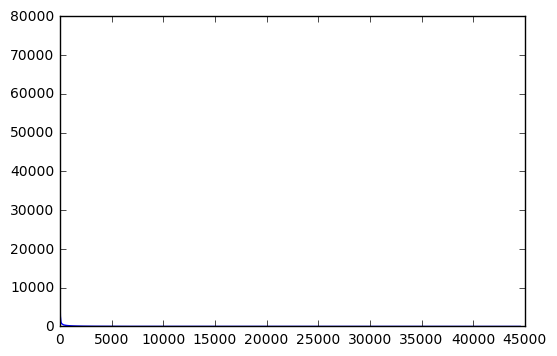

In [24]:
visualizeWordDistribution(articleCaptionLang)

In [24]:
print(random.choice(pairs))

('Investors in World Wrestling Entertainment were dealt a blow this week after stocks fell at the end of the st annual WrestleMania blowout. Shares rallied a little in after hours trading after falling to . at close on Monday.', 'WWE stock slammed despite record breaking WrestleMania event', array([-0.        ,  4.16756058, -0.        , ..., -0.        ,
       -0.        , -0.        ], dtype=float32))


In [20]:
a = "Radiohead s previously unreleased song Spooks is set to feature in Paul Thomas Anderson s forthcoming film Inherent Vice the first adaptation of a Thomas Pynchon novel. The instrumental surf rock track is included on lead guitarist Jonny Greenwood s soundtrack for the comedy crime drama about a drug addled LA detective investigating the mysterious disappearance of his ex girlfriend in the Seventies"

In [361]:
print(len(word_tokenize(a.lower())))    

64


In [25]:
MAX_LENGTH = 30

In [45]:
def indexes_from_sentence(lang, sentence):
    ids = []
    for w in word_tokenize(sentence.lower()):
        if w not in lang.word2index.keys():
            ids.append(lang.word2index['[UNK]'])
        else:
            ids.append(lang.word2index[w])
            
    ids.insert(0, lang.word2index['[SOS]'])
    ids.append(lang.word2index['[EOS]'])

    return ids

def variable_from_sentence(lang, sentence):
    indexes = indexes_from_sentence(lang, sentence)
    var = Variable(torch.LongTensor(indexes).view(-1, 1))
#     print('var =', var)
    if USE_CUDA: var = var.cuda()
    return var

def variables_from_pair(articleCaptionLang, pair):
    input_variable = variable_from_sentence(articleCaptionLang, pair[0])
    target_variable = variable_from_sentence(articleCaptionLang, pair[1])
   
    image_feature = pair[2]
    if USE_CUDA:
        image_feature = image_feature.cuda()
    return (input_variable, target_variable, image_feature)

In [27]:
training_pair = variables_from_pair(articleCaptionLang, random.choice(pairs))

In [30]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1):
        super(EncoderRNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(input_size, hidden_size)
        
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        
        
    def forward(self, word_inputs, hidden):
        # Note: we run this all at once (over the whole input sequence)
        seq_len = len(word_inputs)
        embedded = self.embedding(word_inputs).view(seq_len, 1, -1)
        output, hidden = self.gru(embedded, hidden)
        return output, hidden

    def init_hidden(self):
        hidden = Variable(torch.zeros(self.n_layers, 1, self.hidden_size))
        if USE_CUDA: hidden = hidden.cuda()
        return hidden

In [ ]:
class EncoderRNN(nn.Module):
    def __init__(self, img_size, input_size, hidden_size, n_layers=1):
        super(EncoderRNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.linear = nn.Linear(img_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        
    def forward(self, img, word_inputs, hidden):
        # Note: we run this all at once (over the whole input sequence)
        seq_len = len(word_inputs)
        embedded = self.embedding(word_inputs).view(seq_len, 1, -1)
        embedded[0] = self.linear(img).view(1, 1, -1)
        output, hidden = self.gru(embedded, hidden)
        return output, hidden

    def init_hidden(self):
        hidden = Variable(torch.zeros(self.n_layers, 1, self.hidden_size))
        if USE_CUDA: hidden = hidden.cuda()
        return hidden

In [38]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, entangled_size, n_layers=1):
        super(EncoderRNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(input_size, hidden_size)
       
        self.gru = LSTM(entangledLSTMCell, input_size, hidden_size , factor_size=hidden_size, entangled_size=entangled_size, batch_first = False)
        
    def forward(self, word_inputs, hidden, tagFeatures):
        # Note: we run this all at once (over the whole input sequence)
        seq_len = len(word_inputs)
        embedded = self.embedding(word_inputs).view(seq_len, 1, -1)
        
        output, hidden =  self.gru(embedded, hx=(hidden,hidden), entangler=tagFeatures)
        
#         output, hidden = self.gru(embedded, hidden)
        return output, hidden

    def init_hidden(self):
        hidden = Variable(torch.zeros(self.n_layers, 1, self.hidden_size))
        if USE_CUDA: hidden = hidden.cuda()
        return hidden

In [31]:
class Attn(nn.Module):
    def __init__(self, method, hidden_size, max_length=MAX_LENGTH):
        super(Attn, self).__init__()
        
        self.method = method
        self.hidden_size = hidden_size
        
        if self.method == 'general':
            self.attn = nn.Linear(self.hidden_size, hidden_size)

        elif self.method == 'concat':
            self.attn = nn.Linear(self.hidden_size * 2, hidden_size)
            self.other = nn.Parameter(torch.FloatTensor(1, hidden_size))

    def forward(self, hidden, encoder_outputs):
        seq_len = len(encoder_outputs)

        # Create variable to store attention energies
        attn_energies = Variable(torch.zeros(seq_len)) # B x 1 x S
        if USE_CUDA: attn_energies = attn_energies.cuda()

        # Calculate energies for each encoder output
        for i in range(seq_len):
            attn_energies[i] = self.score(hidden, encoder_outputs[i])

        # Normalize energies to weights in range 0 to 1, resize to 1 x 1 x seq_len
        return F.softmax(attn_energies).unsqueeze(0).unsqueeze(0)
    
    def score(self, hidden, encoder_output):
        
        if self.method == 'dot':
            energy = hidden.dot(encoder_output)
            return energy
        
        elif self.method == 'general':
            energy = self.attn(encoder_output)
            energy = hidden.dot(energy)
            return energy
        
        elif self.method == 'concat':
            energy = self.attn(torch.cat((hidden, encoder_output), 1))
            energy = self.other.dot(energy)
            return energy

In [32]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, attn_model, hidden_size, output_size, n_layers=1, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        
        # Keep parameters for reference
        self.attn_model = attn_model
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout_p = dropout_p
        
        # Define layers
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size * 2, hidden_size, n_layers, dropout=dropout_p)
        self.out = nn.Linear(hidden_size * 2, output_size)
        
        # Choose attention model
        if attn_model != 'none':
            self.attn = Attn(attn_model, hidden_size)
    
    def forward(self, word_input, last_context, last_hidden, encoder_outputs):
        # Note: we run this one step at a time
        
        # Get the embedding of the current input word (last output word)
        word_embedded = self.embedding(word_input).view(1, 1, -1) # S=1 x B x N
        
        # Combine embedded input word and last context, run through RNN
        rnn_input = torch.cat((word_embedded, last_context.unsqueeze(0)), 2)
        rnn_output, hidden = self.gru(rnn_input, last_hidden)

        # Calculate attention from current RNN state and all encoder outputs; apply to encoder outputs
        attn_weights = self.attn(rnn_output.squeeze(0), encoder_outputs)
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1)) # B x 1 x N
        
        # Final output layer (next word prediction) using the RNN hidden state and context vector
        rnn_output = rnn_output.squeeze(0) # S=1 x B x N -> B x N
        context = context.squeeze(1)       # B x S=1 x N -> B x N
        output = F.log_softmax(self.out(torch.cat((rnn_output, context), 1)))
        
        # Return final output, hidden state, and attention weights (for visualization)
        return output, context, hidden, attn_weights

In [33]:
f_image=open('data/vggfeatures-IND.pickle',"rb")
vgg_features=pickle.load(f_image)
f_image=open('data/vggfeatures-WP.pickle',"rb")
vgg_features1=pickle.load(f_image)
vgg_features=dict(vgg_features, **vgg_features1)

In [34]:
f_image=open('data/vggfeatures-IND.pickle',"rb")
vgg_features1=dict(pickle.load(f_image))
# vgg_features=dict(vgg_features, **vgg_features1)

In [39]:
a = "b83d8680253561e90705ce42af8d0f4deb33a286.txt"

In [40]:
aName = a.split(".")[0]
print(aName)

b83d8680253561e90705ce42af8d0f4deb33a286


In [41]:
vgg_features1[aName]

array([-0.        , -0.        ,  1.19822621, ..., -0.        ,
       -0.        , -0.        ], dtype=float32)

In [12]:
vggFeaturesKeyList = list(vgg_features.keys())
for i in range(10):
    vggFeatureKey = vggFeaturesKeyList[i]
    print(vggFeatureKey)
    print(vgg_features[vggFeatureKey])

b83d8680253561e90705ce42af8d0f4deb33a286
[-0.         -0.          1.19822621 ..., -0.         -0.         -0.        ]
8ca8cb29e5df5932aff18d1143b05cd0262b6b6e
[ 0.34955347 -0.         -0.         ..., -0.         -0.          1.24109232]
a395523c9b5dc5b39bb505171763121fe72a49b2
[ 2.11561298 -0.         -0.         ..., -0.          1.64500403
  0.26022199]
3ca1e6745c41d1424d54f6b1e7a7c87f40cd3852
[-0.         -0.         -0.         ..., -0.         -0.          0.03353977]
c48b838b44549a6191bdaff4f2161a5247f8e6bf
[-0.        -0.        -0.        ..., -0.         1.0676744 -0.       ]
08268aa056c9ae548a6e6eab05550b6a63b04315
[-0.         -0.         -0.         ..., -0.         -0.          0.15161002]
784817a62af57c03f7863c213e2a6e753339527a
[-0.         -0.         -0.         ..., -0.         -0.          2.45507145]
0f1f579ec0898852dec60c7c0031dfc0cc9e3afd
[-0. -0. -0. ..., -0. -0. -0.]
1bed0d947a56b60a9060fd616b2ecd1e9e5a5b2b
[-0. -0. -0. ..., -0. -0. -0.]
58e72f733d7e8fd1b08da

In [35]:
teacher_forcing_ratio = 0.5
clip = 5.0

def train(articleCaptionLang, input_variable, target_variable, vggFeature, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    # Zero gradients of both optimizers
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    loss = 0 # Added onto for each word
    
     # Get size of input and target sentences
    input_length = input_variable.size()[0]
    target_length = target_variable.size()[0]
    
    # Run words through encoder
    encoder_hidden = encoder.init_hidden()
    encoder_outputs, encoder_hidden = encoder(input_variable, encoder_hidden, vggFeature)
    
    decoder_input = Variable(torch.LongTensor([[articleCaptionLang.word2index['[SOS]']]]))
    decoder_context = Variable(torch.zeros(1, decoder.hidden_size))
    decoder_hidden = encoder_hidden
    if USE_CUDA:
        decoder_input = decoder_input.cuda()
        decoder_context = decoder_context.cuda()
        
    use_teacher_forcing = random.random() < teacher_forcing_ratio
    if use_teacher_forcing:
        for di in range(target_length):
            decoder_output, decoder_context, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_context, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output[0], target_variable[di])
            decoder_input = target_variable[di]
    else:
        for di in range(target_length):
            decoder_output, decoder_context, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_context, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output[0], target_variable[di])
            
            topv, topi = decoder_output.data.topk(1)
            ni = topi[0][0]
            
            decoder_input = Variable(torch.LongTensor([[ni]]))
            if USE_CUDA: decoder_input = decoder_input.cuda()
                
            if ni==articleCaptionLang.word2index['[EOS]']:
                break
                
    loss.backward()
    torch.nn.utils.clip_grad_norm(encoder.parameters(), clip)
    torch.nn.utils.clip_grad_norm(decoder.parameters(), clip)
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    return loss.data[0]/target_length

In [36]:
def as_minutes(s):
    m = math.floor(s/60)
    s -= m*60
    return "%dm %ds"%(m, s)

def time_since(since, percent):
    now = time.time()
    s = now-since
    es = s/percent
    rs = es - s
    
    return "%s (-%s)"%(as_minutes(s), as_minutes(rs))

In [39]:
attn_model = "general"
hidden_size = 500
n_layers = 4
dropout_p = 0.05
entangled_size = 4096

encoder = EncoderRNN(articleCaptionLang.n_words, hidden_size, entangled_size, n_layers)
decoder = AttnDecoderRNN(attn_model, hidden_size, articleCaptionLang.n_words, n_layers, dropout_p=dropout_p)

if USE_CUDA:
    encoder.cuda()
    decoder.cuda()
    
learning_rate = 0.0001
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)

criterion = nn.NLLLoss()

In [40]:
n_epochs = 50000
plot_every = 800
print_every = 400

start = time.time()
plot_losses = []
print_loss_total = 0
plot_loss_total = 0

In [41]:
totalPairNum = len(pairs)

print(totalPairNum)

20190


In [42]:
from random import shuffle

In [43]:
shuffle(pairs)
trainingNum = int(totalPairNum*0.8)
trainingPairs = pairs[:trainingNum]
testingPairs = pairs[trainingNum:]

In [44]:
for epoch in range(1, n_epochs+1):
    training_pair = variables_from_pair(articleCaptionLang, random.choice(trainingPairs))
    input_variable = training_pair[0]
    target_variable = training_pair[1]
    vggFeature = training_pair[2]
    
    loss = train(articleCaptionLang, input_variable, target_variable, vggFeature, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
    
    print_loss_total += loss
    plot_loss_total += loss
    
    if epoch == 0:continue
        
    if epoch%print_every == 0:
        print_loss_avg = print_loss_total /print_every
        print_loss_total = 0
        print_summary = "%s (%d %d %%) %.4f"%(time_since(start, epoch/n_epochs), epoch, epoch/n_epochs*100, print_loss_avg)
        print(print_summary)
        
    if epoch%plot_every == 0:
        plot_loss_avg = plot_loss_total / plot_every
        plot_losses.append(plot_loss_avg)
        plot_loss_total = 0

RuntimeError: cuda runtime error (59) : device-side assert triggered at /home/soumith/local/builder/wheel/pytorch-src/torch/lib/THC/generic/THCTensorCopy.c:18

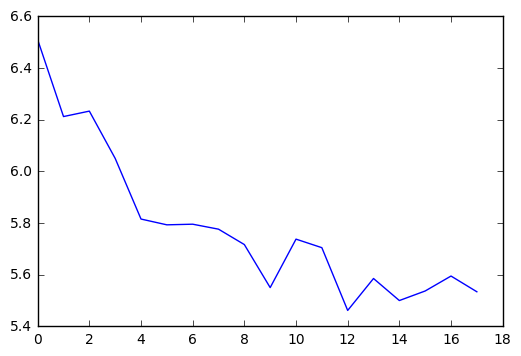

In [149]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
%matplotlib inline

def show_plot(points):
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    
show_plot(plot_losses)

In [150]:
def evaluate(sentence, max_length=MAX_LENGTH):
    input_variable = variable_from_sentence(articleCaptionLang, sentence)
    input_length = input_variable.size()[0]
    
    # Run through encoder
    encoder_hidden = encoder.init_hidden()
    encoder_outputs, encoder_hidden = encoder(input_variable, encoder_hidden)

    # Create starting vectors for decoder
    decoder_input = Variable(torch.LongTensor([[articleCaptionLang.word2index['[SOS]']]])) # SOS
    decoder_context = Variable(torch.zeros(1, decoder.hidden_size))
    if USE_CUDA:
        decoder_input = decoder_input.cuda()
        decoder_context = decoder_context.cuda()

    decoder_hidden = encoder_hidden
    
    decoded_words = []
    decoder_attentions = torch.zeros(max_length, max_length)
    
    # Run through decoder
    for di in range(max_length):
        decoder_output, decoder_context, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_context, decoder_hidden, encoder_outputs)
#         decoder_attentions[di,:decoder_attention.size(2)] += decoder_attention.squeeze(0).squeeze(0).cpu().data

        # Choose top word from output
        topv, topi = decoder_output.data.topk(1)
        ni = topi[0][0]
        if ni == articleCaptionLang.word2index['[EOS]']:
            decoded_words.append('<EOS>')
            break
        else:
            decoded_words.append(articleCaptionLang.index2word[ni])
            
        # Next input is chosen word
        decoder_input = Variable(torch.LongTensor([[ni]]))
        if USE_CUDA: decoder_input = decoder_input.cuda()
    
    return decoded_words, decoder_attentions[:di+1, :len(encoder_outputs)]

In [151]:
def evaluate_randomly():
    pair = random.choice(pairs)
    
    output_words, decoder_attn = evaluate(pair[0])
    output_sentence = ' '.join(output_words)
    
    print('>', pair[0])
    print('=', pair[1])
    print('<', output_sentence)
    print('')

In [152]:
evaluate_randomly()

RuntimeError: cuda runtime error (2) : out of memory at /home/soumith/local/builder/wheel/pytorch-src/torch/lib/THC/generic/THCStorage.cu:66